## Use Energy map to Dynamically resize image width

## Instructions 

> Code will run sequentially just execute the cells in order in the CAPE env

> Make sure images are in same path as where the jupyter notebook was started 

# Import packages

In [31]:
import cv2
import numpy as np
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt

## import image

In [21]:
fig5 = cv2.imread("fig5.png", cv2.IMREAD_COLOR)

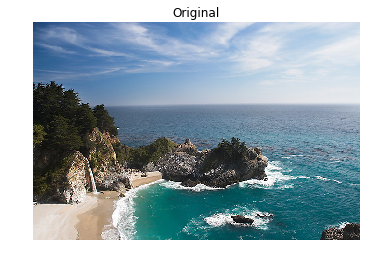

In [32]:
# recombine the color channels
def order_colors(img):
    channels = blue, green, red = np.rollaxis(img, 2)
    rgb_img = np.dstack([red, green, blue])
    return rgb_img

plt.imshow(order_colors(fig5)); plt.axis("off"); plt.title("Original");

In [15]:
# image = cv2.imread("lenacolor512.tiff", cv2.IMREAD_COLOR)  # uint8 image
# norm_image = cv2.normalize(fig5, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

## Create Funtions

In [33]:
def get_energy_matrix(img): 
    gray_scl = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
 
    # X derivative of the image 
    sob_x = cv2.Sobel(gray_scl ,cv2.CV_64F,1, 0, ksize=3) 
 
    # Y derivative of the image 
    sob_y = cv2.Sobel(gray_scl, cv2.CV_64F,0, 1, ksize=3) 
     #take absolute values
    absolute_sob_x = cv2.convertScaleAbs(sob_x) 
    absolute_sob_y = cv2.convertScaleAbs(sob_y) 
    #get the aveage of the gradients
    get_average= cv2.addWeighted(absolute_sob_x, 0.5,absolute_sob_y, 0.5, 0) 
    return get_average

In [34]:
def cumulative_energy_matrix(energy_matrix):
    energy_matrix=energy_matrix.astype('float64')
    cum_energy_matrix = np.zeros(energy_matrix.shape)
    # starts at second row 
    rows=energy_matrix.shape[0]
    cols= energy_matrix.shape[1]
    for row in range(0,rows):    
        for col in range(cols):
            #matrix values 
            mv= energy_matrix[row,col]
            if row == 0:
                cum_energy_matrix[row,:]= energy_matrix[row,:]
            # first column case
            if (row>0 ) and col == 0 :
                cum_energy_matrix[row,col] = \
                        min(cum_energy_matrix[row-1,col],cum_energy_matrix[row-1,col+1]) +mv
            # middle column cases 
            if row > 0 and col != 0 and  col != (cols-1) :
                cum_energy_matrix[row,col] = \
                        min(cum_energy_matrix[row-1,col],cum_energy_matrix[row-1,col+1],cum_energy_matrix[row-1,col-1]) +mv
            # case for edge 
            if row > 0 and   col ==(cols-1) :
                cum_energy_matrix[row,col] = \
                    min(cum_energy_matrix[row-1,col],cum_energy_matrix[row-1,col-1]) +mv
    return cum_energy_matrix


In [35]:
def get_seam(cum_en):
    ## get trues for minimum in last row
    rows=cum_en.shape[0]
    cols=cum_en.shape[1]
    min_truth=cum_en[rows-1,:]==cum_en[rows-1,np.argmin(cum_en[rows-1,:])]

    ## get indices base

    energy_value_path= []

    #create list to house indices of path 
    indices_for_min_path=[]
    for iterator , indices in enumerate(np.argwhere(min_truth)):
        col_list=[indices[0]]
        row_list=[rows-1]
        ### start the search back up 
        for iterator2, backrow in enumerate(range(rows-2,-1,-1)):
            above=cum_en[backrow,col_list[iterator2]]
            
            #conditions for being on left edge, replace with above result
            if col_list[iterator2] != 0:
                left =cum_en[backrow,col_list[iterator2]-1]
            else:
                left =above
                
            # conditions for right , replace with above result
            if col_list[iterator2] != cols -1:
                right=cum_en[backrow,col_list[iterator2]+1]
            else:
                right=above
            
            #print( left, above, right)
            min_=min(left, above, right)
            row_list.append(backrow)
            
            if min_ == above:
                col_list.append(col_list[iterator2])
                continue
            if min_ == left:
                col_list.append(col_list[iterator2]-1)
                continue

            if min_ == right:
                col_list.append(col_list[iterator2]+1)
                continue

        #          print( row_list[iterator2+1],col_list[iterator2+1])
        #         print('break row')
        #append indices
        indices_for_min_path.append([row_list,col_list])
        #append energy sum for path 
        energy_value_path.append(cum_en[row_list,col_list].sum())


        #print('break min col ')
    ## convert to np array
    en_sum_array=np.array(energy_value_path)

    ## get index of most minimal path to preserve entropy

    most_minimal_locator=np.argmin(en_sum_array)

    #get indices of path
    most_minimal_path=indices_for_min_path[most_minimal_locator]
    
    return most_minimal_path

In [36]:
def remove_seam(image,most_minimal_path):
    restack=[]
    reverse_col_list=list(reversed(most_minimal_path[1]))
    for  row_, col_ in enumerate(reverse_col_list):
        whole_row=image[row_,:,:]
        #the cols become the rows here since each is (cols,by 3)
        part_row=np.delete(whole_row,col_,axis=0)
        restack.append(part_row)
    reduce_image = np.array(restack)    
    return reduce_image

In [37]:
def dynamic_width_reduce(img, target_width):
    for i in range(target_width):
        if i == 0:
            #compute energy matrix
            energy_matrix=get_energy_matrix(img)

            #compute cumulative energy matrix
            cum_en=cumulative_energy_matrix(energy_matrix)

            #get minimal seam path , indicices to remove
            minimal_seam_path= get_seam(cum_en)

            # remove lowest energy seam
            reduced_image = remove_seam(img,minimal_seam_path)
        else:
            #compute energy matrix
            energy_matrix=get_energy_matrix(reduced_image)

            #compute cumulative energy matrix
            cum_en=cumulative_energy_matrix(energy_matrix)

            #get minimal seam path , indicices to remove
            minimal_seam_path= get_seam(cum_en)

            # remove lowest energy seam
            reduced_image = remove_seam(reduced_image,minimal_seam_path)
    
    return reduced_image

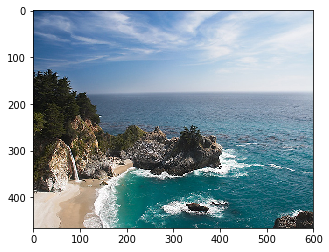

In [38]:
reduced= dynamic_width_reduce(fig5, 100)
plt.imshow(order_colors(reduced))

### Reduce to same ratio as reduced image on authors website

In [17]:
reduce = dynamic_width_reduce(fig5, 350)
reduced.shape

In [24]:
reduce_same=cv2.resize(reduce,(173,230))

In [25]:
reduce_final=order_colors(reduce_same)
plt.imsave('reduce_width_final.png',reduce_final)

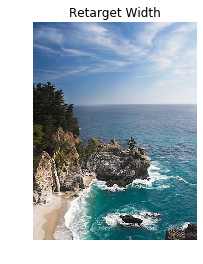

In [29]:
plt.imshow(reduce_final);plt.title('Retarget Width');plt.axis('off');